In [1]:
import numpy as np
import os
from cellpose import utils, io, models
from cellpose import plot
import matplotlib.pyplot as plt
from PIL import Image
from scipy.optimize import curve_fit
from scipy.integrate import quad
from skimage.io import imread
import imgaug.augmenters as iaa
import cv2
import json
from scipy.spatial import KDTree
import random

In [2]:
def ctc_2_CNet_track(path_X,suff_X,path_Y,suff_Y,start_ind,mu,shape,half=True,prompt='hela_ctc',alt=0,save_dir_org='/home/mo/Desktop/IWR/Cell_GT_Proj/CNet_cells_track/',test=False,step=1,specific_i=None):
    
    #data=[]
    test_entries = []
    train_entries = []
    l_ind=start_ind
    if specific_i is not None:
        end=1
    else:
        end=999
        
    save_dir=save_dir_org
    save_dir_test=save_dir.replace('train', 'test')
    
    if not os.path.exists(save_dir + '/target/'):
        os.makedirs(save_dir + '/target/')
        
    if not os.path.exists(save_dir + '/source/'):
        os.makedirs(save_dir + '/source/')
        
    if not os.path.exists(save_dir_test + '/target/'):
        os.makedirs(save_dir_test + '/target/')
        
    if not os.path.exists(save_dir_test + '/source/'):
        os.makedirs(save_dir_test + '/source/')
        
    for i in range(end):
        test=False
        save_dir=save_dir_org
        
        
        try:
            ind=i+step
            path_r_X0 = path_X +'/' +suff_X + '{:03d}'.format(ind) + '.tif'
            path_r_Y0 = path_Y+'/TRA/'+suff_Y+'{:03d}'.format(ind)+'.tif'
            path_r_X1 = path_X +'/' +suff_X + '{:03d}'.format(i) + '.tif'
            path_r_Y1 = path_Y+'/TRA/'+suff_Y+'{:03d}'.format(i)+'.tif'

            if specific_i is not None:

                path_r_X0 = path_X + suff_X + '{:03d}'.format(specific_i+1) + '.tif'
                path_r_Y0 = path_Y + suff_Y + '{:03d}'.format(specific_i+1) + '.tif'
                path_r_X1 = path_X + suff_X + '{:03d}'.format(specific_i) + '.tif'
                path_r_Y1 = path_Y + suff_Y + '{:03d}'.format(specific_i) + '.tif'





            img_r_X0 = imread(path_r_X0)
            img_r_Y0 = imread(path_r_Y0)
            img_r_X1 = imread(path_r_X1)
            img_r_Y1 = imread(path_r_Y1)

            max_X = np.max(img_r_X0)
            img_r_X0 = (img_r_X0/max_X)*255
            img_r_X1 = (img_r_X1/max_X)*255


            if half:
                #print('shape',shape)
                start_x = np.random.randint(0, int(shape[1]/2))
                end_x = start_x + int(shape[1]/2)
                start_y = np.random.randint(0, int(shape[0]/2))
                end_y = start_y + int(shape[0]/2)
                #print(start_y,end_y, start_x,end_x)
                # Crop the random region from img_r_X
                img_r_X0 = img_r_X0[start_y:end_y, start_x:end_x]
                img_r_X1 = img_r_X1[start_y:end_y, start_x:end_x]
                img_r_Y0 = img_r_Y0[start_y:end_y, start_x:end_x]
                img_r_Y1 = img_r_Y1[start_y:end_y, start_x:end_x]





            probability = 0.1  # 10% probability

            # Generate a random number between 0 and 1
            random_number = random.random()

            # Check if the random number is less than the desired probability
            if random_number < probability:
                test=True
                #print('is_True',)

            if test:
                save_dir=save_dir_test

            with open(path_Y+'/TRA/'+'man_track.txt', 'r') as file:
                lineage = file.readlines()


            img_r_Y1=connect_matching_dots(img_r_Y0,img_r_Y1,path_Y+'/TRA/',ind,img_r_X0,i+step,mu,lineage=lineage)
            
            
            number_of_images = count_images_in_directory(save_dir + '/target/')
            if (save_dir == save_dir_test and number_of_images < 20) or save_dir != save_dir_test:
            
                output_path_X0 = save_dir + '/target/' + str(start_ind + i + 1)+'_'+ str(i)+ '.png'
                output_path_Y0 = save_dir + '/source/' + str(start_ind + i + 1) +'_'+ str(i)+ '.png'
                output_path_X1 = save_dir + '/target/' + str(start_ind + i) + '_'+ str(i)+'.png'
                output_path_Y1 = save_dir + '/source/' + str(start_ind + i) + '_'+ str(i)+'.png'


                img_r_Y1 = (img_r_Y1).astype(np.uint8)


                img_r_X1,img_r_Y1=augment_images(img_r_X1, img_r_Y1, alt)

                #cv2.imwrite(output_path_Y0, combined_imag0)
                cv2.imwrite(output_path_Y1, img_r_Y1)
                #cv2.imwrite(output_path_X0, img_r_X0)
                cv2.imwrite(output_path_X1, img_r_X1)
                l_ind = l_ind + 1
                #print('out',output_path_X1)
                #print(stop)




                entry = {
                "source": 'source/' + str(start_ind + i) + '_'+ str(i)+'.png',
                "target": 'target/' + str(start_ind + i) + '_'+ str(i)+'.png',
                "prompt": prompt
                }

                # Append the entry to the data list
                #data.append(entry)

                if test:
                    test_entries.append(entry)

                else:
                    train_entries.append(entry)




                        # Write the data list as JSON to a file



        except Exception as e:
            if not str(e).startswith("[Errno 2]"):
                 traceback.print_exc()
                    #print("An error occurred:", str(e))

    save_list=[save_dir,save_dir_test]    
    for h in range(2): 
        save_dir=save_list[h]
        if h==0:
            data = train_entries
        else:
            data = test_entries
    
        output_path = save_dir+"/prompt.json"    
        existing_data = []



        # Read existing data from the JSON file, if it exists
        try:
            with open(output_path, "r") as infile:
                for line in infile:
                    line = line.strip()  # Remove leading/trailing whitespaces
                    if line:
                        data_j = json.loads(line)
                        existing_data.append(data_j)
        except FileNotFoundError:
            pass

        #print('!!!!!!ex',existing_data)
        #print('!!!!!!dat',data)
        # Append new entries to the existing data
        existing_data=existing_data+data
        #print('!!!!!!ex2',existing_data)

        # Write the updated data to the JSON file
        with open(output_path, "w") as outfile:
            for entry in existing_data:
                #print('ent',entry)
                json.dump(entry, outfile)
                outfile.write('\n') 

    return l_ind



def count_images_in_directory(directory_path):
    return sum([len(files) for r, d, files in os.walk(directory_path)])


def connect_matching_dots(img1, img2, path, t, cells, frame,mu,test=False, deep=False, lineage=None):
    # Find unique pixel values and their counts in both images
    unique_values_1, counts_1 = np.unique(img1, return_counts=True)
    unique_values_2, counts_2 = np.unique(img2, return_counts=True)
    counts_2_dict = dict(zip(unique_values_2, counts_2))
    
    # Create an output image for dots and lines separately
    output_img_dots = np.zeros_like(img1)
    output_img_lines = np.zeros_like(img1)
    output_img_splits = np.zeros_like(img1)

    # Initialize 3-channel image with zeros
    output_img_dots = np.stack((output_img_dots,)*3, axis=-1)
    output_img_lines = np.stack((output_img_lines,)*3, axis=-1)
    output_img_splits = np.stack((np.zeros_like(img1),)*3, axis=-1)

    # Draw dots in blue
    output_img_dots[:, :, 2] = cells  
    radius = int(np.sqrt(mu / np.pi) / 4) if int(np.sqrt(mu / np.pi) / 4) > 2 else 2

    # Draw lines and circles in green
    for value in unique_values_1[unique_values_1 > 0]:
        # Find the coordinates of matching dots in both images
        coordinates_img1 = np.argwhere(img1 == value)
        coordinates_img2 = np.argwhere(img2 == value)

        if coordinates_img2.size > 0: 
            
            
            coord1 = np.mean(coordinates_img1, axis=0, dtype=int)
            coord2 = np.mean(coordinates_img2, axis=0, dtype=int)
            
            flag=check_split_timeframe(frame, value, lineage)

            # Define the radius for this specific point
            
            if test:
                coord2 = test_transform(coord1, coord2)
            
            if flag==0:
                cv2.line(output_img_lines, tuple(coord1[::-1]), tuple(coord2[::-1]), color=[55, 200, 0], thickness=3)
                cv2.circle(output_img_lines, tuple(coord2[::-1]), radius, color=[0, 255, 0], thickness=-1) # Filled circle
            elif flag==1:
                cv2.line(output_img_lines, tuple(coord1[::-1]), tuple(coord2[::-1]), color=[55, 200, 0], thickness=3)
                cv2.circle(output_img_lines, tuple(coord2[::-1]), radius, color=[255, 255, 0], thickness=-1) # Filled circle
            elif flag==2:
                #print('flag2',t,frame)
                cv2.line(output_img_lines, tuple(coord1[::-1]), tuple(coord2[::-1]), color=[55, 200, 0], thickness=3)
                cv2.circle(output_img_lines, tuple(coord2[::-1]), radius, color=[170, 255, 0], thickness=-1) # Filled
            elif flag==3:
                #print('flag2',t,frame)
                cv2.line(output_img_lines, tuple(coord1[::-1]), tuple(coord2[::-1]), color=[55, 200, 0], thickness=3)
                cv2.circle(output_img_lines, tuple(coord2[::-1]), radius, color=[85, 255, 0], thickness=-1) # Filled 
            elif flag==-1:
                #print('flag2',t,frame)
                cv2.line(output_img_lines, tuple(coord1[::-1]), tuple(coord2[::-1]), color=[55, 200, 0], thickness=3)
                cv2.circle(output_img_lines, tuple(coord2[::-1]), radius, color=[255, 85, 0], thickness=-1) # Filled 
                
            elif flag==-2:
                #print('flag2',t,frame)
                cv2.line(output_img_lines, tuple(coord1[::-1]), tuple(coord2[::-1]), color=[55, 200, 0], thickness=3)
                cv2.circle(output_img_lines, tuple(coord2[::-1]), radius, color=[255, 170, 0], thickness=-1) # Filled
                
            elif flag==-3:
                #print('flag2',t,frame)
                cv2.line(output_img_lines, tuple(coord1[::-1]), tuple(coord2[::-1]), color=[55, 200, 0], thickness=3)
                cv2.circle(output_img_lines, tuple(coord2[::-1]), radius, color=[255, 170, 0], thickness=-1) # Filled 
                
                
           
        else:
            cs = check_split(path, t, value)
                
            if cs[0]:
                coordinates_img1 = np.argwhere(img1 == value)
                coordinates_img2 = np.argwhere(img2 == cs[1])
                if coordinates_img2.size > 0: 
                    coord1 = np.mean(coordinates_img1, axis=0, dtype=int)
                    coord2 = np.mean(coordinates_img2, axis=0, dtype=int)
                    cv2.line(output_img_splits, tuple(coord1[::-1]), tuple(coord2[::-1]), color=[200, 55, 0], thickness=3)
                    cv2.circle(output_img_splits, tuple(coord2[::-1]), radius, color=[255, 0, 0], thickness=-1)  # Filled circle

    # Stack images along the channel dimension: Red for splits, Green for lines, Blue for dots
    output_img = output_img_dots + output_img_lines + output_img_splits
    return output_img


def check_split(path,t,value):
    data = np.loadtxt(path+'man_track.txt')

    # Split the data into columns
    start = data[:, 1]
    ide = data[:, 0][start==t]
    
    end = data[:, 2][start==t]
    parent = data[:, 3][start==t]
    
    try:
        par = parent[ide==value]
        print('p_t_pa_v',par,t,path,value)
        
        if len(ide[parent==par])==2:
            print('ide',ide[parent==par])
            return True,par[0]
        else:
            return False,0
        
    except:
        return False,0
    
def parse_lineage_data(data):
    """
    Convert the given lineage data to a list of dictionaries.
    """
    result = []
    for line in data:
        L, B, E, P = map(int, line.split())
        result.append({
            'label': L,
            'frame_start': B,
            'frame_end': E,
            'parent': P
        })
    return result

def check_split_timeframe(t, cell_id, lineage_data):
    """
    Check the time difference for the given cell_id and timeframe t.
    """
    parsed_data = parse_lineage_data(lineage_data)

    # Finding the cell with the given cell_id
    current_cell = None
    for cell in parsed_data:
        if cell['label'] == cell_id:
            current_cell = cell
            break
    else:
        # Cell not found
        return 0

    # If the cell has a parent (indicating it has emerged from a merge)
    if current_cell['parent'] != 0:
        time_difference_from_merge = t - current_cell['frame_start']
        if time_difference_from_merge == 1:
            return -1
        elif time_difference_from_merge == 2:
            return -2
        elif time_difference_from_merge == 3:
            return -3

    # Check if the cell will merge soon with another cell
    for cell in parsed_data:
        if cell['parent'] == current_cell['label']:
            merge_point = cell['frame_start']
            time_difference_to_next_merge = merge_point - t

            if time_difference_to_next_merge == 1:
                return 1
            elif time_difference_to_next_merge == 2:
                return 2
            elif time_difference_to_next_merge == 3:
                return 3

    return 0


# Reading the file


def ctc_2_CNet(path_X,path_Y,suff_X,suff_Y,start_ind,mu,shape,half=True,prompt='hela_ctc',alt=0,save_dir='/home/mo/Desktop/IWR/Cell_GT_Proj/CNet_cells/',test=False):
    
    
    end=999
    
    if test:
        save_dir=save_dir.replace('train', 'test')
        end=10
    
    if not os.path.exists(save_dir + '/target/'):
        os.makedirs(save_dir + '/target/')
        
    if not os.path.exists(save_dir + '/source/'):
        os.makedirs(save_dir + '/source/')
    
    
    data=[]
    l_ind=start_ind
    for i in range(end):
        
        try:
            path_r_X=path_X+'/'+suff_X+'{:03d}'.format(i)+'.tif'
            path_r_Y=path_Y+'/TRA/'+suff_Y+'{:03d}'.format(i)+'.tif'
            # read the tif file
            #print('p',path_r)
            #try:
            #img_r_X = tiff.imread(path_r_X)
            #img_r_Y = tiff.imread(path_r_Y)
            img_r_X = imread(path_r_X)
            img_r_Y = imread(path_r_Y)


            max_X=np.max(img_r_X)
            img_r_X = (img_r_X/max_X)*255
            max_y=np.max(img_r_Y)
            img_r_Y = (img_r_Y/max_y)*255


            if half:
                #print('shape',shape)
                start_x = np.random.randint(0, int(shape[1]/2))
                end_x = start_x + int(shape[1]/2)
                start_y = np.random.randint(0, int(shape[0]/2))
                end_y = start_y + int(shape[0]/2)
                #print(start_y,end_y, start_x,end_x)
                # Crop the random region from img_r_X
                img_r_X = img_r_X[start_y:end_y, start_x:end_x]

                # Crop the random region from img_r_Y
                img_r_Y = img_r_Y[start_y:end_y, start_x:end_x]

            #print('both shapes',img_r_X.shape,img_r_Y.shape)
            img_r_X,img_r_Y=augment_images(img_r_X, img_r_Y,alt=alt)


            #if alt==1:
            #    cv2.imwrite(output_path_Y_c, img_r_Y)


            img_r_Y,pos_list = source2CNet(img_r_Y, mu,test=test)
            
            if test:
                file_path = os.path.join(save_dir, 'numbers.txt')
                if not os.path.exists(file_path):
                    with open(file_path, 'w') as f:
                        f.write("image\tnumber of cells\n")

                        # Determine number of cells
                        if pos_list is not None and len(pos_list) > 0:
                            num_cells = len(pos_list)
                        else:
                            num_cells = 0

                        f.write(f"{start_ind+i}\t{num_cells}\n")
                else:
                    with open(file_path, 'a') as f:
                        # Determine number of cells
                        if pos_list is not None and len(pos_list) > 0:
                            num_cells = len(pos_list)
                        else:
                            num_cells = 0

                        f.write(f"{start_ind+i}\t{num_cells}\n")

                #print('pos',pos_list,len(pos_list))

            #print('source worked')

            # Specify the output file path





            output_path_X = save_dir+'/target/'+str(start_ind+i)+'.png'
            output_path_Y = save_dir+'/source/'+str(start_ind+i)+'.png'
            #output_path_Y_c = save_dir+'source/'+str(start_ind+i)+'contr.png'



            # Save the resized image as PNG
            cv2.imwrite(output_path_X, img_r_X)
            cv2.imwrite(output_path_Y, img_r_Y)


            entry = {
            "source": "source/" + str(start_ind+i) + ".png",
            "target": "target/" + str(start_ind+i) + ".png",
            "prompt": prompt
            }

            # Append the entry to the data list
            data.append(entry)

            l_ind=l_ind+1

                # Write the data list as JSON to a file


        
        except Exception as e:
            if not str(e).startswith("[Errno 2]"):
                traceback.print_exc()
            #print("An error occurred:", str(e))
        
        
        
    output_path = save_dir + "/prompt.json"

    # Check if file exists, if not create it
    if not os.path.exists(output_path):
        open(output_path, 'a').close()   
    existing_data = []



    # Read existing data from the JSON file, if it exists
    try:
        with open(output_path, "r") as infile:
            for line in infile:
                line = line.strip()  # Remove leading/trailing whitespaces
                if line:
                    data_j = json.loads(line)
                    existing_data.append(data_j)
    except FileNotFoundError:
        pass

    #print('!!!!!!ex',existing_data)
    #print('!!!!!!dat',data)
    # Append new entries to the existing data
    existing_data=existing_data+data
    #print('!!!!!!ex2',existing_data)

    # Write the updated data to the JSON file
    with open(output_path, "w") as outfile:
        for entry in existing_data:
            #print('ent',entry)
            json.dump(entry, outfile)
            outfile.write('\n')    
        
    return l_ind





def mean_ind(indices):
    """Get the mean indices from a list of indices."""
    return np.mean(indices, axis=0)

def source2CNet(img, mu,test=False):
    # Find unique values and their counts, ignoring zeros
    unique_values, unique_counts = np.unique(img, return_counts=True)
    non_zero_mask = unique_values != 0
    unique_values = unique_values[non_zero_mask]
    unique_counts = unique_counts[non_zero_mask]

    # Lists to store the mean position of each unique value and their respective counts
    pos_list = []
    count_list = []

    for value in unique_values:
        mask = img == value
        indices = np.argwhere(mask)
        m_ind = mean_ind(indices)
        pos_list.append(m_ind)

    # Initialize an output image of zeros
    image_tensor = np.zeros_like(img, dtype=np.uint8)
    
    if test:
        #print('pos_list_before',pos_list)
        pos_list = generate_similar_positions2(pos_list)
    
    # Determine the radius for the painted dots
    radius = int(np.sqrt(mu / np.pi) / 4) if int(np.sqrt(mu / np.pi) / 4) > 2 else 2

    
    # Iterate over the mean positions and draw the dots
    for position in pos_list:
        x, y = int(position[0]), int(position[1])
        
        # Draw a dot on the image_tensor around this position
        for i in range(-radius, radius + 1):
            for j in range(-radius, radius + 1):
                if (i**2 + j**2 <= radius**2):
                    try:
                        image_tensor[x+i, y+j] = 255
                    except IndexError:
                        pass

    return image_tensor, pos_list


def generate_similar_positions2(positions):
    # Calculate pairwise distances
    positions = np.array(positions)
    pairwise_distances = np.linalg.norm(positions[:, None] - positions, axis=2)

    # Get the minimum distance from the pairwise_distances
    min_distance = np.min(pairwise_distances + np.eye(pairwise_distances.shape[0]) * np.max(pairwise_distances))

    # Create an empty list for new positions
    new_positions = []

    # Initial random position
    new_positions.append(np.random.uniform(low=positions.min(axis=0), high=positions.max(axis=0)))

    # Maximal number of attempts to generate a point that keeps minimal distance
    max_attempts = 1000
    attempts = 0

    while len(new_positions) < len(positions):
        if attempts > max_attempts:
            print("Cannot generate desired number of positions with the current minimal distance.")
            break

        # Sample random point
        random_point = np.random.uniform(low=positions.min(axis=0), high=positions.max(axis=0))

        # Construct KDTree
        tree = KDTree(new_positions)

        # Get the distances and indices of the closest points to the random_point
        distances, indices = tree.query(random_point, k=1)

        # Check if the minimum distance condition holds
        if distances >= min_distance:
            new_positions.append(random_point.tolist())
        else:
            attempts += 1

    # Convert list to numpy array
    if len(new_positions) > 1 and random.random() < 0.70:
        n = np.random.randint(1, len(new_positions))
        new_positions = np.array(new_positions[0:n])

        
    else:
        new_positions = np.array(new_positions)
        

    return new_positions

def list_target_directories(path):
    # A set of names we are looking for
    target_names = {f"{i:02}" for i in range(1, 100)} # assuming 01 to 99 as the possible names

    # List to store the directories found
    found_dirs = []

    # Walk through the root directory
    for dirpath, dirnames, filenames in os.walk(path):
        for dirname in dirnames:
            if dirname in target_names:
                found_dirs.append(os.path.join(dirpath, dirname))
    
    return found_dirs

def cellpose_segmentation(path,diameter=None):
    model = models.Cellpose(gpu=False, model_type='cyto2')
    chan = [0,0]
    directories=list_target_directories(path)
    print(directories)
    #print(stop)
    for directory in directories:
        # Get a list of all tif files in the directory
        files = [f for f in os.listdir(directory) if f.endswith('.tif') or f.endswith('.TIF')]

        for f in files:
            # Create output filename
            output_filename = f.replace('.tif', '_cp_masks.png').replace('.TIF', '_cp_masks.png')
            output_filepath = os.path.join(directory+'_CP', output_filename)
            print('out',output_filepath)
            # Check if the output file already exists. If it does, skip computation and saving
            if os.path.exists(output_filepath):
                print(f"{output_filename} already exists. Skipping...")
                continue

            print(f)
            img = io.imread(directory+'/'+f)
            masks, flows, styles, diams = model.eval(img, diameter=diameter, channels=chan)

            # save results so you can load in gui
            io.masks_flows_to_seg(img, masks, flows, diams, f, chan)
            unique_values, unique_counts = np.unique(masks, return_counts=True)
            print(masks,masks.shape,unique_values,len(unique_values)-1)

            # save results as png
            io.save_to_png(img, masks, flows, directory+'_CP/'+f)
            fig = plt.figure(figsize=(12,5))
            plot.show_segmentation(fig, img, masks, flows[0], channels=chan)
            plt.tight_layout()
            plt.show()
    
def generate_CTC_datasets(path,name,save_dir,diameter):
    cellpose_segmentation(path,diameter=diameter)
    mu,sig,n,b,shape=process_images(path)
    #print('shape_before!!!',shape)
    generate_XY_pairs(path,mu,sig,shape,name, save_dir)
    

def process_images(root_path):
    all_pixel_counts = []
    all_displacements = []

    # For area calculation
    for dirpath, dirnames, filenames in os.walk(root_path):
        if os.path.basename(dirpath).endswith('_CP') and os.path.basename(dirpath)[:2].isdigit():
            for file in filenames:
                if file.endswith('.png'):
                    img_path = os.path.join(dirpath, file)
                    img = np.array(Image.open(img_path))
                    unique_values, counts = np.unique(img, return_counts=True)
                    all_pixel_counts.extend(counts[unique_values != 0])

    first_image_shape = None
    
    for dirpath, dirnames, filenames in os.walk(root_path):
        if (os.path.basename(dirpath) == 'TRA' and 
            os.path.dirname(dirpath).endswith('_GT') and 
            os.path.basename(os.path.dirname(dirpath))[:2].isdigit()):

            filenames = sorted([f for f in filenames if f.startswith('man_track') and f.endswith('.tif')])
            print('filenames',filenames)
            for idx in range(len(filenames) - 1):
                img1_path = os.path.join(dirpath, filenames[idx])
                img2_path = os.path.join(dirpath, filenames[idx + 1])

                img1 = np.array(Image.open(img1_path))
                img2 = np.array(Image.open(img2_path))

                # Check image shapes
                if first_image_shape is None:
                    first_image_shape = img1.shape
                assert img1.shape == first_image_shape, f"Image {img1_path} has a different shape {img1.shape} than the first image shape {first_image_shape}"
                assert img2.shape == first_image_shape, f"Image {img2_path} has a different shape {img2.shape} than the first image shape {first_image_shape}"

                displacements = calculate_displacement(img1, img2)
                all_displacements.extend(displacements)

    # Plotting
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Histogram for pixel counts
    hist_vals, bin_edges = np.histogram(all_pixel_counts, bins=75)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    popt, _ = curve_fit(one_gaussian, bin_centers, hist_vals, p0=(max(hist_vals), np.mean(all_pixel_counts), np.std(all_pixel_counts)))
    A, mu, sigma = popt
    ax[0].bar(bin_centers, hist_vals, width=np.diff(bin_edges)[0], edgecolor='black', label='Histogram Data', alpha=0.6)
    ax[0].plot(bin_centers, one_gaussian(bin_centers, *popt), 'r-', label='Fitted Gaussian')
    ax[0].set_title('Histogram of Areas Across All Images with Fitted Gaussian')
    ax[0].set_xlabel('Area (Pixel Count)')
    ax[0].set_ylabel('Number of Regions')
    ax[0].legend()

    # Histogram for displacements
    hist_vals, bin_edges = np.histogram(all_displacements, bins=50)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    #popt, _ = curve_fit(one_gaussian, bin_centers, hist_vals, p0=(max(hist_vals), np.mean(all_displacements), np.std(all_displacements)))
    ax[1].bar(bin_centers, hist_vals, width=np.diff(bin_edges)[0], edgecolor='black', label='Histogram Data', alpha=0.6)
    #popt, _ = curve_fit(half_gaussian, bin_centers, hist_vals, p0=(max(hist_vals), np.std(all_displacements)))
    initial_guess = [max(hist_vals), 2]  # A rough guess for A and n
    popt, _ = curve_fit(inverse_power_law, bin_centers[1:], hist_vals[1:], p0=initial_guess)  # We exclude the first bin since x=0 will cause division by zero
    #ax[1].plot(bin_centers, half_gaussian(bin_centers, *popt), 'r-', label='Fitted Half-Gaussian')
    A_opt, n_opt = popt
    b = int((1/0.05)**(1/n_opt))
    print('image_shapes',first_image_shape)
    print('opt',A_opt,n_opt,b,np.max(all_displacements))
    ax[1].plot(bin_centers, inverse_power_law(bin_centers, A_opt, n_opt), 'r-', label='Fitted 1/x^n curve')

    ax[1].set_title('Histogram of Displacements with Fitted Gaussian')
    ax[1].set_xlabel('Displacement (Pixels)')
    ax[1].set_ylabel('Number of Displacements')
    ax[1].legend()

    plt.tight_layout()
    plt.show()
    
    return mu,sigma,n_opt,np.max(all_displacements),first_image_shape

def one_gaussian(x, A1, mu1, sigma1):
    g1 = A1 * np.exp(-(x - mu1)**2 / (2 * sigma1**2))
    return g1
   
def half_gaussian(x, amplitude, sigma):
    return amplitude * np.sqrt(2/np.pi) * np.exp(-x**2 / (2 * sigma**2)) / sigma

def inverse_power_law(x, A, n):
    return A / (x ** n)


def power_law_pdf(x, n, A):
    return A / (x ** n)

# Normalization constant A for defined interval [1, b]
def find_A(n, b=10):
    integral, _ = quad(power_law_pdf, 1, b, args=(n, 1))
    return 1 / integral

# CDF of the power-law function
def power_law_cdf(x, n, A):
    def integrand(t):
        return power_law_pdf(t, n, A)
    result, _ = quad(integrand, 1, x)
    return result

# Inverse of CDF
def inverse_cdf(u, n, A, b=10):
    # Using a simple binary search for the inverse
    low, high = 1, b
    while high - low > 1e-6:
        mid = (low + high) / 2
        if power_law_cdf(mid, n, A) < u:
            low = mid
        else:
            high = mid
    return (low + high) / 2

# Sampling from the power-law function
def sample_from_power_law(n, b=10, size=1):
    A = find_A(n, b)
    u = np.random.rand(size)
    samples = [inverse_cdf(ui, n, A, b) for ui in u]
    return np.array(samples)


#samples = sample_from_power_law(n, b,size=5000)

    
def calculate_displacement(img1, img2):
    displacements = []

    unique_values1 = np.unique(img1)
    unique_values1 = unique_values1[unique_values1 != 0]

    unique_values2 = np.unique(img2)
    unique_values2 = unique_values2[unique_values2 != 0]

    for val in unique_values1:
        if val in unique_values2:
            y1, x1 = np.where(img1 == val)
            y2, x2 = np.where(img2 == val)

            mean_coord1 = [np.mean(x1), np.mean(y1)]
            mean_coord2 = [np.mean(x2), np.mean(y2)]

            distance = np.sqrt((mean_coord1[0] - mean_coord2[0])**2 + (mean_coord1[1] - mean_coord2[1])**2)
            displacements.append(distance)

    return displacements

def augment_images(image_X, image_Y, alt):

    # Rotate the images based on the 'alt' value
    rotate_degrees = alt * 90  # Rotate by 90, 180, 270, or 360 degrees
    aug = iaa.Affine(rotate=rotate_degrees)
    augmented_images = aug(images=[image_X, image_Y])
    
    # Return the augmented images
    augmented_image_X, augmented_image_Y = augmented_images
    return augmented_image_X, augmented_image_Y

def generate_pos_pairs(path,mu,sig,shape,name, save_dir,num_cut_outs=3):
    suff_X = 't'
    suff_Y= 'man_track'
    path_X, path_Y = find_folders(path)
    prompt_ctc='cell, microscopy, image'
    l_ind=0
    alt=[0,1,2,3]
    save_dir_0=save_dir+'_'+str(int(shape[1]/2))+'_'+str(int(shape[0]/2))
    for g in range(num_cut_outs):
        for k in range(len(path_X)):
            for h in range(len(alt)):
                l_ind=ctc_2_CNet(path_X[k],path_Y[k],suff_X,suff_Y,start_ind=l_ind,mu=mu,shape=shape,half=True,prompt=prompt_ctc,alt=alt[h],save_dir=save_dir_0,test=False)
                #print(l_ind)
    l_ind=0            
    for k in range(len(path_X)):
        for h in range(1):
                l_ind=ctc_2_CNet(path_X[k],path_Y[k],suff_X,suff_Y,start_ind=l_ind,mu=mu,shape=shape,half=True,prompt=prompt_ctc,alt=0,save_dir=save_dir_0,test=True)
                #print(l_ind)
        
    l_ind=0    
    save_dir_0=save_dir+'_'+str(int(shape[1]))+'_'+str(int(shape[0]))
    for k in range(len(path_X)):
        for h in range(len(alt)):
            l_ind=ctc_2_CNet(path_X[k],path_Y[k],suff_X,suff_Y,start_ind=l_ind,mu=mu,shape=shape,half=False,prompt=prompt_ctc,alt=alt[h],save_dir=save_dir_0,test=False)
    
    l_ind=0
    for k in range(len(path_X)):
        for h in range(1):
                l_ind=ctc_2_CNet(path_X[k],path_Y[k],suff_X,suff_Y,start_ind=l_ind,mu=mu,shape=shape,half=False,prompt=prompt_ctc,alt=0,save_dir=save_dir_0,test=True)
                #print(l_ind)

def find_folders(root_path):
    path_X = []
    path_Y = []
    
    for dirpath, dirnames, filenames in os.walk(root_path):
        for dirname in dirnames:
            # Check if folder name matches the pattern XX
            if len(dirname) == 2 and dirname.isdigit():
                path_X.append(os.path.join(dirpath, dirname))
            # Check if folder name matches the pattern XX_GT
            elif dirname.endswith('_GT') and len(dirname) == 5 and dirname[:2].isdigit():
                path_Y.append(os.path.join(dirpath, dirname))
                
    return path_X, path_Y
    
    
def generate_track_pairs(path,mu,sig,shape,name, save_dir,num_cut_outs=3):

    
    suff_X = 't' 
    suff_Y='man_track'
    prompt_ctc='cell, microscopy, image'
    path_X, path_Y = find_folders(path)
    l_ind=0
    alt=[0,1,2,3]
    steps=[1]
    
    parts = save_dir.rsplit('/', 1)  # Split based on the last slash
    name_parts = parts[1].split('_')  # Split the "HeLa_train" part

    # Now we construct save_dir_0
    save_dir_0= save_dir+'_'+'track'+'_'+str(int(shape[1]/2))+'_'+str(int(shape[0]/2))#= f"{parts[0]}/{name_parts[0]}_track_{name_parts[1]}_{int(shape[1]/2)}_{int(shape[0]/2)}"
    #print('save_dir_old',save_dir+'_'+'track'+'_'+str(int(shape[1]/2))+'_'+str(int(shape[0]/2)))
    #print('save_dir_new',save_dir_0)
    #print(stop)
    #save_dir_0=save_dir+'_'+'track'+'_'+str(int(shape[1]/2))+'_'+str(int(shape[0]/2))
    for g in range(num_cut_outs):
        for k in range(len(path_X)):
            for q in steps:
                for h in range(len(alt)):
                    l_ind=ctc_2_CNet_track(path_X[k],suff_X,path_Y[k],suff_Y,start_ind=l_ind,mu=mu,shape=shape,half=True,prompt=prompt_ctc,alt=alt[h],save_dir_org=save_dir_0,step=q)
                    print(l_ind)
                    
    l_ind=0
    save_dir_0 = save_dir+'_'+'track'+'_'+str(int(shape[1]))+'_'+str(int(shape[0]))
    for k in range(len(path_X)):
        for q in steps:
            for h in range(len(alt)):
                l_ind=ctc_2_CNet_track(path_X[k],suff_X,path_Y[k],suff_Y,start_ind=l_ind,mu=mu,shape=shape,half=False,prompt=prompt_ctc,alt=alt[h],save_dir_org=save_dir_0,step=q)
                print(l_ind)
    
    
def generate_XY_pairs(path,mu,sig,shape,name, save_dir):
    
    #generate_pos_pairs(path,mu,sig,shape,name, save_dir)
    generate_track_pairs(path,mu,sig,shape,name, save_dir)



['/home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01', '/home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/02']
out /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_CP/t064_cp_masks.png
t064_cp_masks.png already exists. Skipping...
out /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_CP/t007_cp_masks.png
t007_cp_masks.png already exists. Skipping...
out /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_CP/t072_cp_masks.png
t072_cp_masks.png already exists. Skipping...
out /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_CP/t022_cp_masks.png
t022_cp_masks.png already exists. Skipping...
out /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_CP/t029_cp_masks.png
t029_cp_masks.png already exists. Skipping...
out /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_CP/t043_cp_masks.png
t043_cp_masks.png already exists. Skipping...
out /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-

filenames ['man_track000.tif', 'man_track001.tif', 'man_track002.tif', 'man_track003.tif', 'man_track004.tif', 'man_track005.tif', 'man_track006.tif', 'man_track007.tif', 'man_track008.tif', 'man_track009.tif', 'man_track010.tif', 'man_track011.tif', 'man_track012.tif', 'man_track013.tif', 'man_track014.tif', 'man_track015.tif', 'man_track016.tif', 'man_track017.tif', 'man_track018.tif', 'man_track019.tif', 'man_track020.tif', 'man_track021.tif', 'man_track022.tif', 'man_track023.tif', 'man_track024.tif', 'man_track025.tif', 'man_track026.tif', 'man_track027.tif', 'man_track028.tif', 'man_track029.tif', 'man_track030.tif', 'man_track031.tif', 'man_track032.tif', 'man_track033.tif', 'man_track034.tif', 'man_track035.tif', 'man_track036.tif', 'man_track037.tif', 'man_track038.tif', 'man_track039.tif', 'man_track040.tif', 'man_track041.tif', 'man_track042.tif', 'man_track043.tif', 'man_track044.tif', 'man_track045.tif', 'man_track046.tif', 'man_track047.tif', 'man_track048.tif', 'man_trac

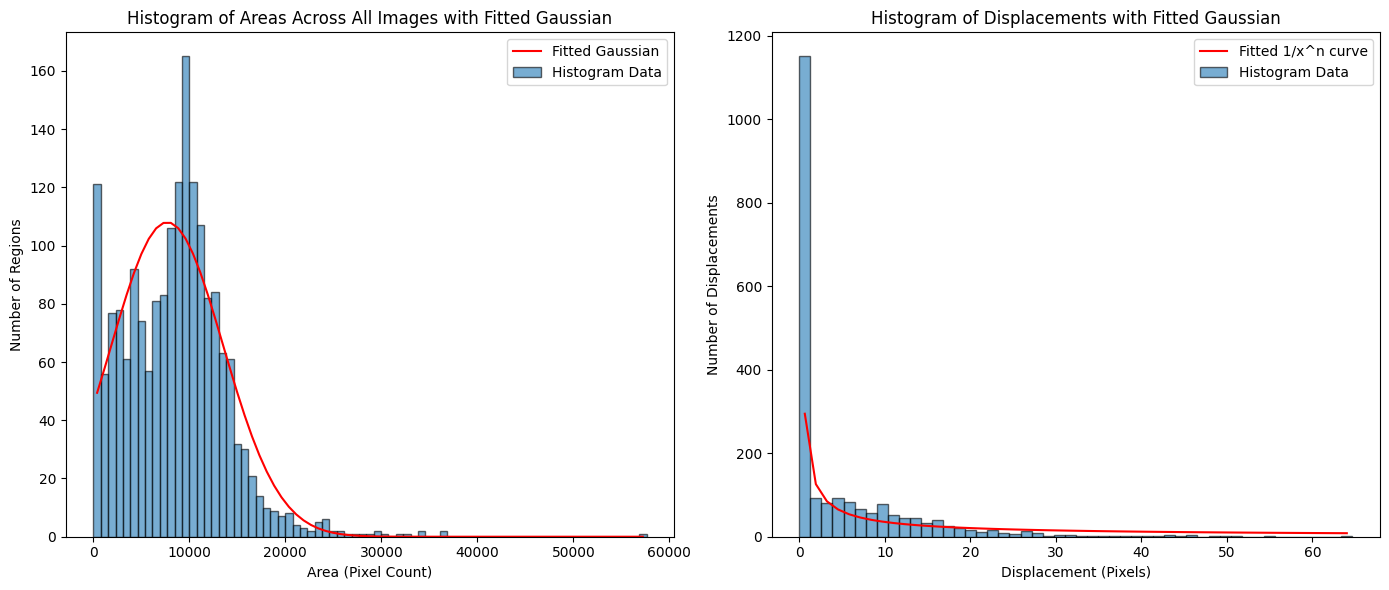

p_t_pa_v [] 5 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_GT/TRA/ 23
p_t_pa_v [19.] 11 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_GT/TRA/ 21
ide [21. 22.]
p_t_pa_v [19.] 11 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_GT/TRA/ 22
ide [21. 22.]
p_t_pa_v [] 16 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_GT/TRA/ 23
p_t_pa_v [] 20 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_GT/TRA/ 11
p_t_pa_v [] 21 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_GT/TRA/ 23
p_t_pa_v [15.] 22 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_GT/TRA/ 16
ide [16. 18.]
p_t_pa_v [15.] 22 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_GT/TRA/ 18
ide [16. 18.]
p_t_pa_v [] 33 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_GT/TRA/ 18
p_t_pa_v [7.] 36 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_GT/TRA/ 8
ide [ 8. 10.]
p_t_pa_v [7.] 36 /

/tmp/ipykernel_63993/1304325249.py:295: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if len(ide[parent==par])==2:


p_t_pa_v [] 77 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/02_GT/TRA/ 17
p_t_pa_v [9.] 78 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/02_GT/TRA/ 12
ide [11. 12.]
393
p_t_pa_v [0.] 1 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/02_GT/TRA/ 41
p_t_pa_v [] 20 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/02_GT/TRA/ 9
p_t_pa_v [] 24 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/02_GT/TRA/ 5
p_t_pa_v [28.] 26 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/02_GT/TRA/ 44
ide [43. 44.]
p_t_pa_v [] 27 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/02_GT/TRA/ 5
p_t_pa_v [0.] 35 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/02_GT/TRA/ 35
p_t_pa_v [] 43 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/02_GT/TRA/ 5
p_t_pa_v [13.] 46 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/02_GT/TRA/ 17
ide [16. 17.]
p_t_pa_v [1.] 49 /home/mo/Desktop/IWR/Cell_GT_P

p_t_pa_v [11.] 62 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_GT/TRA/ 12
ide [12. 14.]
p_t_pa_v [11.] 62 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_GT/TRA/ 14
ide [12. 14.]
p_t_pa_v [32.] 64 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_GT/TRA/ 36
ide [35. 36.]
p_t_pa_v [23.] 66 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_GT/TRA/ 26
ide [24. 26.]
p_t_pa_v [] 72 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_GT/TRA/ 30
843
p_t_pa_v [1.] 30 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_GT/TRA/ 3
ide [3. 4.]
p_t_pa_v [1.] 30 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_GT/TRA/ 4
ide [3. 4.]
p_t_pa_v [] 30 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_GT/TRA/ 23
p_t_pa_v [7.] 36 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_GT/TRA/ 10
ide [ 8. 10.]
p_t_pa_v [11.] 62 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-He

p_t_pa_v [1.] 30 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_GT/TRA/ 3
ide [3. 4.]
p_t_pa_v [1.] 30 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_GT/TRA/ 4
ide [3. 4.]
p_t_pa_v [7.] 36 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_GT/TRA/ 8
ide [ 8. 10.]
p_t_pa_v [7.] 36 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_GT/TRA/ 10
ide [ 8. 10.]
p_t_pa_v [] 36 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_GT/TRA/ 16
p_t_pa_v [] 48 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_GT/TRA/ 27
p_t_pa_v [] 50 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_GT/TRA/ 3
p_t_pa_v [] 52 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_GT/TRA/ 11
p_t_pa_v [11.] 62 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_GT/TRA/ 12
ide [12. 14.]
p_t_pa_v [11.] 62 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_GT/TRA/ 14
ide [12. 14.]
p_t_pa_v [

p_t_pa_v [] 60 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/02_GT/TRA/ 4
p_t_pa_v [] 71 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/02_GT/TRA/ 6
p_t_pa_v [9.] 78 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/02_GT/TRA/ 11
ide [11. 12.]
p_t_pa_v [9.] 78 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/02_GT/TRA/ 12
ide [11. 12.]
p_t_pa_v [] 79 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/02_GT/TRA/ 11
p_t_pa_v [] 82 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/02_GT/TRA/ 12
1738
p_t_pa_v [] 23 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/02_GT/TRA/ 28
p_t_pa_v [0.] 35 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/02_GT/TRA/ 35
p_t_pa_v [] 43 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/02_GT/TRA/ 5
p_t_pa_v [13.] 46 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/02_GT/TRA/ 16
ide [16. 17.]
p_t_pa_v [13.] 46 /home/mo/Desktop/IWR/Cell_GT_

p_t_pa_v [15.] 22 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_GT/TRA/ 16
ide [16. 18.]
p_t_pa_v [15.] 22 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_GT/TRA/ 18
ide [16. 18.]
p_t_pa_v [1.] 30 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_GT/TRA/ 3
ide [3. 4.]
p_t_pa_v [1.] 30 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_GT/TRA/ 4
ide [3. 4.]
p_t_pa_v [0.] 34 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_GT/TRA/ 54
p_t_pa_v [7.] 36 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_GT/TRA/ 8
ide [ 8. 10.]
p_t_pa_v [7.] 36 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_GT/TRA/ 10
ide [ 8. 10.]
p_t_pa_v [0.] 51 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_GT/TRA/ 55
p_t_pa_v [0.] 57 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_GT/TRA/ 56
p_t_pa_v [27.] 60 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/01_GT/TRA/ 28


p_t_pa_v [13.] 46 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/02_GT/TRA/ 16
ide [16. 17.]
p_t_pa_v [13.] 46 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/02_GT/TRA/ 17
ide [16. 17.]
p_t_pa_v [1.] 49 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/02_GT/TRA/ 2
ide [2. 4.]
p_t_pa_v [1.] 49 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/02_GT/TRA/ 4
ide [2. 4.]
p_t_pa_v [5.] 54 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/02_GT/TRA/ 6
ide [6. 8.]
p_t_pa_v [5.] 54 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/02_GT/TRA/ 8
ide [6. 8.]
p_t_pa_v [0.] 54 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/02_GT/TRA/ 36
p_t_pa_v [0.] 60 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/02_GT/TRA/ 19
ide [19. 20.]
p_t_pa_v [0.] 60 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa/02_GT/TRA/ 20
ide [19. 20.]
p_t_pa_v [0.] 69 /home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2

In [3]:
path='/home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/DIC-C2DH-HeLa'
name='HeLa'
save_path='/home/mo/Desktop/IWR/Cell_GT_Proj/CTC_datasets/'
diameter=55



save_dir=save_path+name+'_train'

generate_CTC_datasets(path,name,save_dir,diameter)